# Prosper Loan Data Exploration
## by Vilija Vaitkeviciute

## Investigation Overview

The loan data from [Prosper](https://www.prosper.com/), an online lending platform that connects people who want to borrow money with individuals and institutions, is explored here.  The loan data includes loan characteristics, Prosper's internal tracking data, borrower profile and some lender information.

**The analysis will focus on understanding how the lender's estimated returns relate to various factors, and how the estimated returns available from loans have evolved over time. **

This question is of interest to potential lenders, who may not be familiar with loan pricing mechanism, or even to auditors and competitors.  

## Dataset Overview

There are 84,853 observations in the dataset (abreviated to include only post 13-July-2009 observations), where 13-July-2009 marks introduction of EstimatedReturn, EstimatedLoss, Estimated Yield, ProsperScore and other key variables to the analysis.

The dataset contains 81 features, of which majority are numerical (61), categorical (17) and boolean (3); some of the numerical variables are numerical categories or ratings (such as 'ProsperRating (numeric)', ListingCategory, ProsperScore). 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

#set style
sns.set(style='white')

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv')

In [3]:
#converting all dates to datetime
df.ListingCreationDate = pd.to_datetime(df.ListingCreationDate)
df.LoanOriginationDate = pd.to_datetime(df.LoanOriginationDate)
df.DateCreditPulled = pd.to_datetime(df.DateCreditPulled)
df.ClosedDate = pd.to_datetime(df.ClosedDate)

In [4]:
# LoanStatus into ordered categorical type
loanstatus_order = ['Current', 'FinalPaymentInProgress', 'Completed',  'Past Due (1-15 days)',
                    'Past Due (16-30 days)', 'Past Due (31-60 days)', 'Past Due (61-90 days)', 
                    'Past Due (91-120 days)', 'Past Due (>120 days)', 'Defaulted',
                    'Chargedoff']

ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = loanstatus_order)
df.LoanStatus = df.LoanStatus.astype(ordered_var)

In [5]:
# Cut all observations before Eatimated Return (Yield, Loss) are available
min_date = min(df[~df.EstimatedReturn.isnull()].ListingCreationDate)
df = df[df.ListingCreationDate>= min_date]

In [6]:
# Variables created for analysis
df['LoanLossRatio'] = df.LP_NetPrincipalLoss/df.LoanOriginalAmount
df['CreditScoreMid'] = (df.CreditScoreRangeUpper+df.CreditScoreRangeLower)/2
df['FriendInvestmentRatio'] = df.InvestmentFromFriendsAmount / df.LoanOriginalAmount

In [7]:
# Reduce dataframe size to variables analised here
df = df[['EstimatedReturn', 'EstimatedEffectiveYield',  'EstimatedLoss', 
         'LP_NetPrincipalLoss', 'LoanOriginalAmount', 'LoanLossRatio',
         'InquiriesLast6Months', 'CurrentDelinquencies', 'DelinquenciesLast7Years', 
         'BankcardUtilization', 'AvailableBankcardCredit', 
         'CreditScoreMid',  
         'DebtToIncomeRatio', 'StatedMonthlyIncome', 'MonthlyLoanPayment', 'IsBorrowerHomeowner', 'Occupation',
         'Term', 'ListingCategory (numeric)', 'LoanStatus',
         'ListingCreationDate', 'LoanOriginationDate', 'ClosedDate',
         'InvestmentFromFriendsAmount', 'FriendInvestmentRatio']]

# Create a datafrae that contains no negative yield observations (cutting 190), used in some of the cases
df_postitive_yield=df[df.EstimatedEffectiveYield>0]

## Loan listings from 2009 to 2014

Distribution of loan listings in time indicate there are a large number of observations accross the analysed date range.  The loan listings increase significantly in time, and thus their various properties can be analysed using, by and large, material sample sizes.

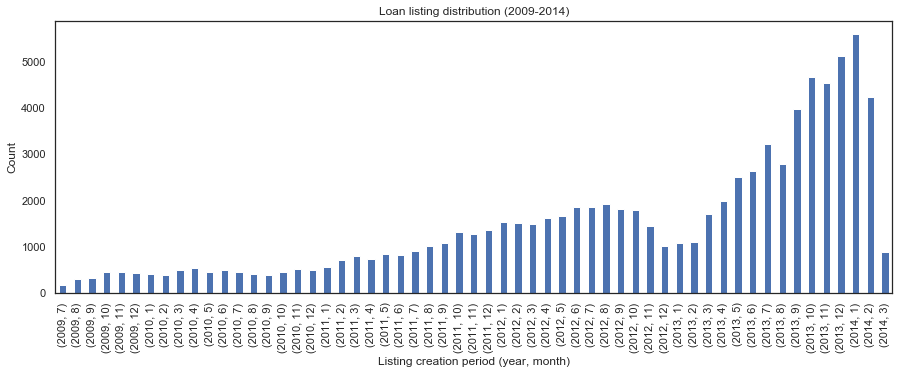

In [8]:
plt.figure(figsize=[15,5])
df.groupby([df.ListingCreationDate.dt.year,df.ListingCreationDate.dt.month])['ListingCreationDate'].count().plot(kind='bar')
plt.xlabel('Listing creation period (year, month)')
plt.ylabel('Count')
plt.title('Loan listing distribution (2009-2014)');

## Estimated return and yield

For all 2009 loans and for large part of 2010 loans, estimated return did not include estimated loss (and thus estimated return was equal to estimated yield, producing perfect straigh line correlation).  This could (and in fact according to newspaper articles, was) be interpreted as misleading loan investors.

Prosper seems to have corrected this error in computing Estimated Returns in late 2010.

Follwoing this, estimated return and estimated yield correlate positively, but not perfectly. 

In addition, the analysis points to increasing steepness in "yearly" cohort of loans, which could be a result of increase in proportion of estimated losses for like for like estimated yields for each "yearly" cohort.

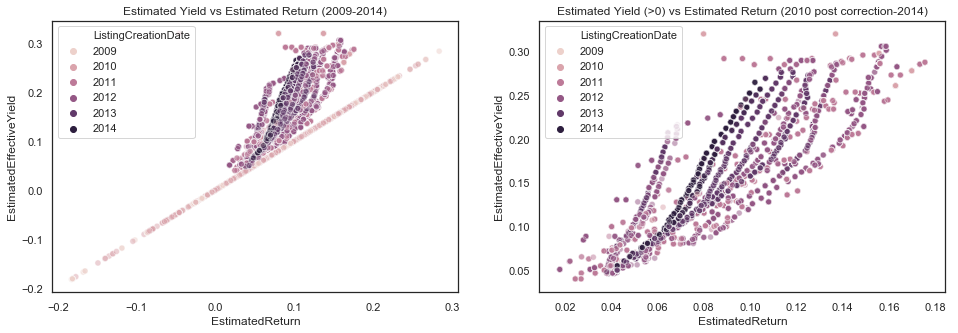

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=[16,5])

sns.scatterplot(data=df, x='EstimatedReturn', y='EstimatedEffectiveYield', 
                hue = df.ListingCreationDate.dt.year, alpha = 0.5, ax=ax[0], legend='full')
ax[0].legend(loc='upper left')
ax[0].set_title('Estimated Yield vs Estimated Return (2009-2014)')

sns.scatterplot(data=df[(df.EstimatedReturn!=df.EstimatedEffectiveYield)&(df.EstimatedReturn>0)], 
                x='EstimatedReturn', y='EstimatedEffectiveYield', hue = df.ListingCreationDate.dt.year, 
                alpha = 0.5, ax=ax[1], legend='full')
ax[1].legend(loc='upper left')
ax[1].set_title('Estimated Yield (>0) vs Estimated Return (2010 post correction-2014)');

## Estimated yield and loss

In 2009-2010 the estimated loss was independed of the estimated yield, and fell into several cohorts according to some variable (other than yield).

Following overhall at the end of 2010, the estimated loss became linearly related to estimated yield (achiving correlation of 0.96), and year after year the loss proportion appears to be slightly higher (as "yearly" curves shift parallely upwards).

In further investigations I will therefore use estimated yield as main dependent variable for investigating relationships with other variables, unless specific case required otherwise.

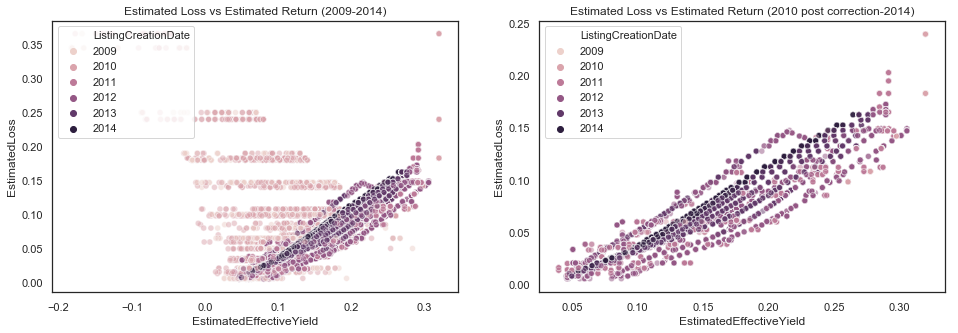

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=[16,5])

sns.scatterplot(data=df, x='EstimatedEffectiveYield', y='EstimatedLoss', 
                hue = df.ListingCreationDate.dt.year, alpha = 0.5, ax=ax[0], legend='full')
ax[0].legend(loc='upper left')
ax[0].set_title('Estimated Loss vs Estimated Return (2009-2014)')


sns.scatterplot(data=df[(df.EstimatedReturn!=df.EstimatedEffectiveYield)&(df.EstimatedReturn>0)], 
                x='EstimatedEffectiveYield', y='EstimatedLoss', hue = df.ListingCreationDate.dt.year, 
                alpha = 0.5, ax=ax[1], legend='full')
ax[1].legend(loc='upper left')
ax[1].set_title('Estimated Loss vs Estimated Return (2010 post correction-2014)');

## Estimated yield vs credit score

Credit score, as supplied by external credit agencies to Prosper, appears to have significant negative correlation with estimated yield. This is to say that higher credit score is related to lower loan yields.

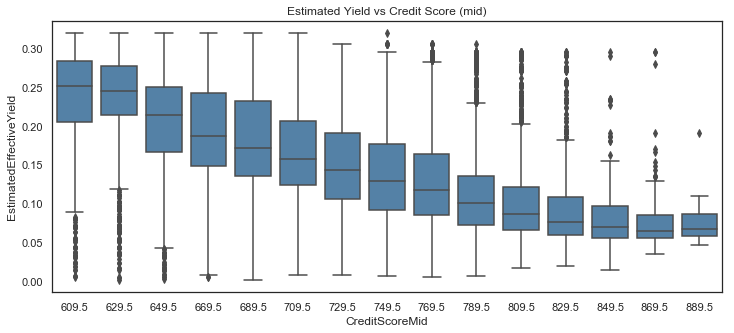

In [11]:
plt.figure(figsize=[12,5])

sns.boxplot(x=df_postitive_yield.CreditScoreMid, y=df_postitive_yield.EstimatedEffectiveYield, color='steelblue')
plt.title('Estimated Yield vs Credit Score (mid)');

## Estimated yield/loss and credit score evolution in time 

Analysis for each loan cohort as divided by year of listing reveals that:
- for each bucket of credit scores, the estimated yields have contracted between 2011 and 2014, following a major rejustment upwards after 2010,
- the declines are the steepest for three middle buckets (together from 651 to 801)
- the estimated losses have also contracted from 2011 to 2014 (as expected due to linear relation with yields), but at slightly lower pace/gradient (again, as observed, where loss as % of yield each year seems to be market higher from 2011 to 2014)

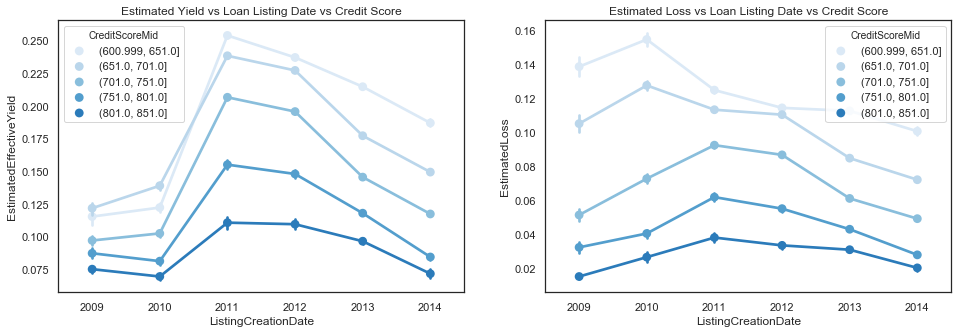

In [12]:
sns.set(style='white')
cred_bins = np.arange(601,901,50)

creditscore_bins = pd.cut(df.CreditScoreMid, cred_bins, include_lowest = True)
creditscore_index= creditscore_bins.value_counts().sort_index().index

fig, ax = plt.subplots(ncols=2, figsize=[16,5])
palette = sns.color_palette("Blues")

sns.pointplot(x = df.ListingCreationDate.dt.year, y = df.EstimatedEffectiveYield, 
              hue = creditscore_bins, 
              ax = ax[0], palette=palette)
ax[0].set_title('Estimated Yield vs Loan Listing Date vs Credit Score')

sns.pointplot(x = df.ListingCreationDate.dt.year, y = df.EstimatedLoss, 
              hue = creditscore_bins,
              ax = ax[1], palette=palette)
ax[1].set_title('Estimated Loss vs Loan Listing Date vs Credit Score');

## Estimated yields and available bank credit as well as debt income ration accross time

As with overall data, the negative relationship between available bank credit and estimated yield, and positive relationship between debt to income ratio and estimated yield are evident accross each year's loan cohort (except, in part, 2009-2010, presumably due to nagative rates).

It's also evident that with each laon cohort from 2011 to 2014, the estimated yields have decreased for the same "credit quality" indicator.

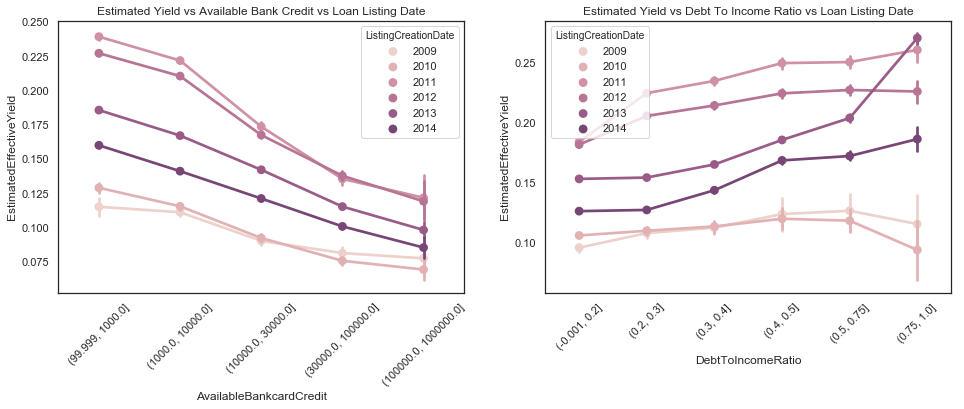

In [13]:
fig, ax = plt.subplots(ncols=2,figsize=[16,5])

palette = sns.cubehelix_palette(8)

ABC_bins = [100,1000,10000,30000, 100000,1000000]
AvailableBankCredit_bins = pd.cut(df.AvailableBankcardCredit, ABC_bins, 
                                  include_lowest = True)
sns.pointplot(x = AvailableBankCredit_bins, y = df.EstimatedEffectiveYield, 
              hue = df.ListingCreationDate.dt.year, 
              ax=ax[0], palette=palette)
ax[0].set_title('Estimated Yield vs Available Bank Credit vs Loan Listing Date')

DTI_bins = [0,0.2,0.3,0.4,0.5,0.75,1]
DebtToIncome_bins = pd.cut(df.DebtToIncomeRatio, DTI_bins, 
                                  include_lowest = True)
sns.pointplot(x = DebtToIncome_bins, y = df.EstimatedEffectiveYield, 
              hue = df.ListingCreationDate.dt.year, 
              ax=ax[1], palette=palette)
ax[1].set_title('Estimated Yield vs Debt To Income Ratio vs Loan Listing Date')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45);

## Loan size variation accross time, and how it relates to estimated yield and credit score over the years

Analysis reveals that:
- Prosper started with issuing smaller loans in 2009 and 2010, and ramped up to larger loans and more loans of all sizes over time,
- Loans of USD 25k and above were associated with borrower's with credit scores of 700 and above,
- For each loan size, higher credit scores on average are associated with lower yields, while lower credit scores are associated with higher yields,
- For each loan size, the decline from 2011 to 2014 of yields (for all credit score borrowers), is evident; and repricing post 2010 is also evident.

*(scroll through 6 sub-slides below to see analysis for each loan amount interval)*

In [14]:
# compute variables/bins for subsequent charts 

years=df_postitive_yield.LoanOriginationDate.dt.year.value_counts().sort_index().index
loan_bins = [0,5100,10100,15100,20100,25100,35100]
creditscore_bins = np.arange(601,901,25)
creditscore_largebins = [600.001,701,901]

OriginalLoanAmount_bins = pd.cut(df_postitive_yield.LoanOriginalAmount, bins=loan_bins, include_lowest = True)
OriginalLoanAmount_index=OriginalLoanAmount_bins.value_counts().sort_index().index

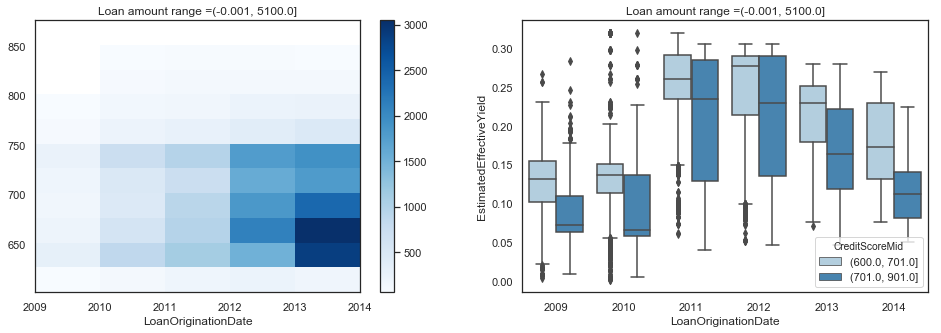

In [15]:
# create sub-slide for each loan size bin - as all six rows will not fit in a slide
# 0-5100

fig, ax = plt.subplots(ncols=2, figsize=[16, 5])

loan_amount = OriginalLoanAmount_index[0]
    
mask = (OriginalLoanAmount_bins == loan_amount)

h = ax[0].hist2d(x=df_postitive_yield[mask].LoanOriginationDate.dt.year, 
                     y=df_postitive_yield[mask].CreditScoreMid, 
                     bins=[years,creditscore_bins], cmap="Blues", cmin = 50)
plt.colorbar(h[3], ax=ax[0])
ax[0].title.set_text('Loan amount range ={}'.format(loan_amount))
ax[0].set_xlabel('LoanOriginationDate')

CreditScore_large_bins = pd.cut(df_postitive_yield[mask].CreditScoreMid, bins=creditscore_largebins, 
                                include_lowest = True)
sns.boxplot(x=df_postitive_yield[mask].LoanOriginationDate.dt.year, 
            y=df_postitive_yield[mask].EstimatedEffectiveYield, 
            hue=CreditScore_large_bins,
            palette='Blues', ax=ax[1])
ax[1].title.set_text('Loan amount range ={}'.format(loan_amount));

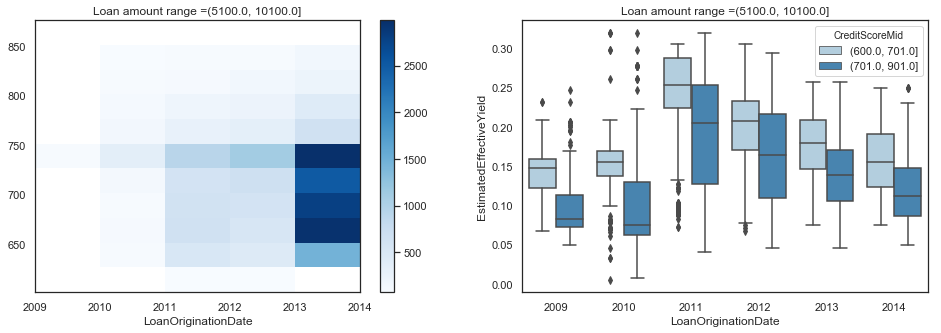

In [16]:
# 5100-10100

fig, ax = plt.subplots(ncols=2, figsize=[16, 5])

loan_amount = OriginalLoanAmount_index[1]
    
mask = (OriginalLoanAmount_bins == loan_amount)

h = ax[0].hist2d(x=df_postitive_yield[mask].LoanOriginationDate.dt.year, 
                     y=df_postitive_yield[mask].CreditScoreMid, 
                     bins=[years,creditscore_bins], cmap="Blues", cmin = 50)
plt.colorbar(h[3], ax=ax[0])
ax[0].title.set_text('Loan amount range ={}'.format(loan_amount))
ax[0].set_xlabel('LoanOriginationDate')


CreditScore_large_bins = pd.cut(df_postitive_yield[mask].CreditScoreMid, bins=creditscore_largebins, 
                                include_lowest = True)
sns.boxplot(x=df_postitive_yield[mask].LoanOriginationDate.dt.year, 
            y=df_postitive_yield[mask].EstimatedEffectiveYield, 
            hue=CreditScore_large_bins,
            palette='Blues', ax=ax[1])
ax[1].title.set_text('Loan amount range ={}'.format(loan_amount));

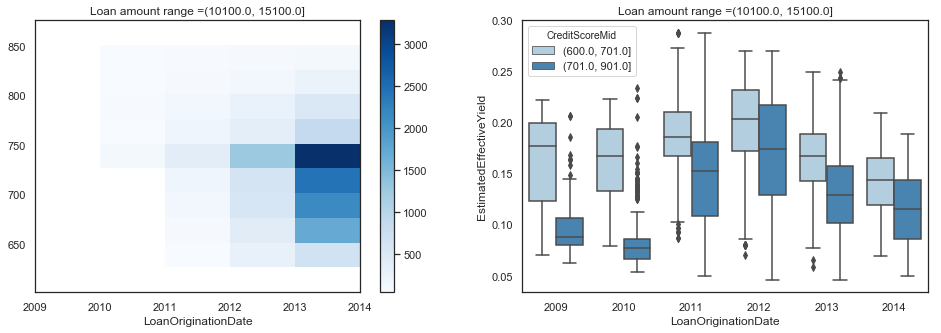

In [17]:
# 10100-15100

fig, ax = plt.subplots(ncols=2, figsize=[16, 5])

loan_amount = OriginalLoanAmount_index[2]
    
mask = (OriginalLoanAmount_bins == loan_amount)

h = ax[0].hist2d(x=df_postitive_yield[mask].LoanOriginationDate.dt.year, 
                     y=df_postitive_yield[mask].CreditScoreMid, 
                     bins=[years,creditscore_bins], cmap="Blues", cmin = 50)
plt.colorbar(h[3], ax=ax[0])
ax[0].title.set_text('Loan amount range ={}'.format(loan_amount))
ax[0].set_xlabel('LoanOriginationDate')

CreditScore_large_bins = pd.cut(df_postitive_yield[mask].CreditScoreMid, bins=creditscore_largebins, 
                                include_lowest = True)
sns.boxplot(x=df_postitive_yield[mask].LoanOriginationDate.dt.year, 
            y=df_postitive_yield[mask].EstimatedEffectiveYield, 
            hue=CreditScore_large_bins,
            palette='Blues', ax=ax[1])
ax[1].title.set_text('Loan amount range ={}'.format(loan_amount));

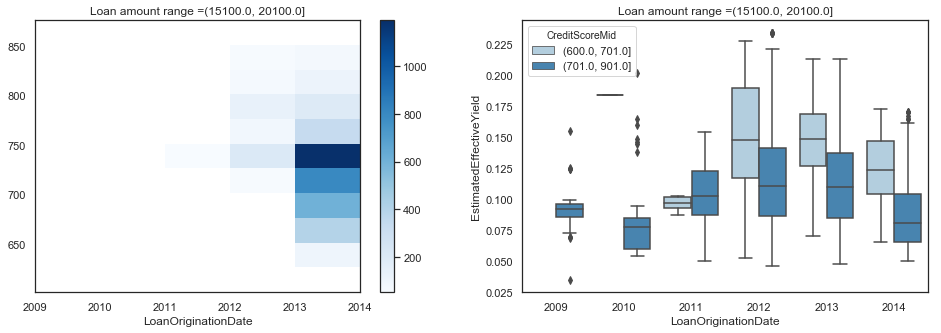

In [18]:
# 15100-20100

fig, ax = plt.subplots(ncols=2, figsize=[16, 5])

loan_amount = OriginalLoanAmount_index[3]
    
mask = (OriginalLoanAmount_bins == loan_amount)

h = ax[0].hist2d(x=df_postitive_yield[mask].LoanOriginationDate.dt.year, 
                     y=df_postitive_yield[mask].CreditScoreMid, 
                     bins=[years,creditscore_bins], cmap="Blues", cmin = 50)
plt.colorbar(h[3], ax=ax[0])
ax[0].title.set_text('Loan amount range ={}'.format(loan_amount))
ax[0].set_xlabel('LoanOriginationDate')

CreditScore_large_bins = pd.cut(df_postitive_yield[mask].CreditScoreMid, bins=creditscore_largebins, 
                                include_lowest = True)
sns.boxplot(x=df_postitive_yield[mask].LoanOriginationDate.dt.year, 
            y=df_postitive_yield[mask].EstimatedEffectiveYield, 
            hue=CreditScore_large_bins,
            palette='Blues', ax=ax[1])
ax[1].title.set_text('Loan amount range ={}'.format(loan_amount));

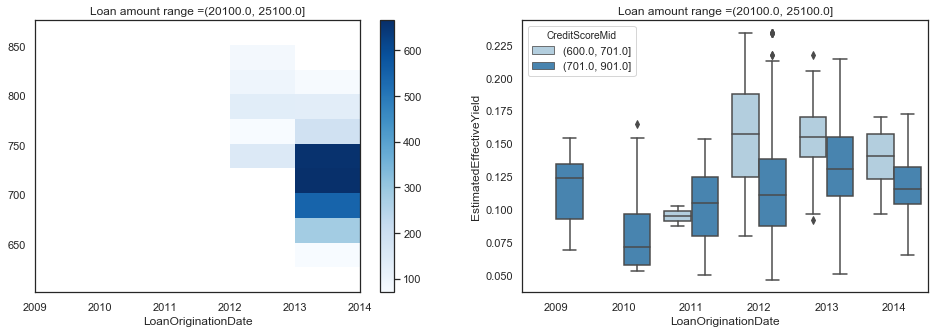

In [19]:
# 15100-25100

fig, ax = plt.subplots(ncols=2, figsize=[16, 5])

loan_amount = OriginalLoanAmount_index[4]
    
mask = (OriginalLoanAmount_bins == loan_amount)

h = ax[0].hist2d(x=df_postitive_yield[mask].LoanOriginationDate.dt.year, 
                     y=df_postitive_yield[mask].CreditScoreMid, 
                     bins=[years,creditscore_bins], cmap="Blues", cmin = 50)
plt.colorbar(h[3], ax=ax[0])
ax[0].title.set_text('Loan amount range ={}'.format(loan_amount))
ax[0].set_xlabel('LoanOriginationDate')

CreditScore_large_bins = pd.cut(df_postitive_yield[mask].CreditScoreMid, bins=creditscore_largebins, 
                                include_lowest = True)
sns.boxplot(x=df_postitive_yield[mask].LoanOriginationDate.dt.year, 
            y=df_postitive_yield[mask].EstimatedEffectiveYield, 
            hue=CreditScore_large_bins,
            palette='Blues', ax=ax[1])
ax[1].title.set_text('Loan amount range ={}'.format(loan_amount));

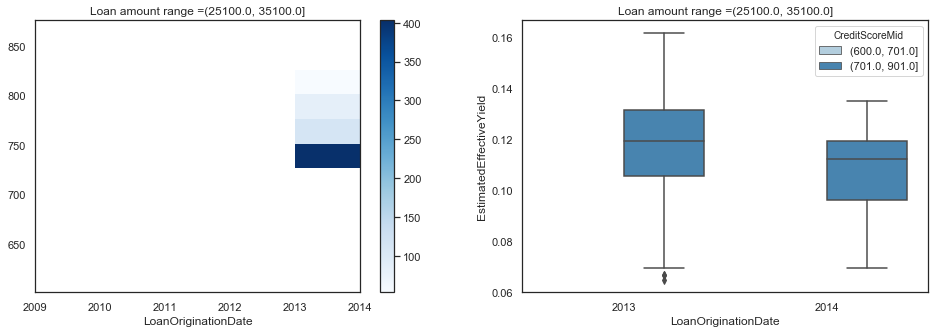

In [20]:
# 25100-35100


fig, ax = plt.subplots(ncols=2, figsize=[16, 5])

loan_amount = OriginalLoanAmount_index[5]
    
mask = (OriginalLoanAmount_bins == loan_amount)

h = ax[0].hist2d(x=df_postitive_yield[mask].LoanOriginationDate.dt.year, 
                     y=df_postitive_yield[mask].CreditScoreMid, 
                     bins=[years,creditscore_bins], cmap="Blues", cmin = 50)
plt.colorbar(h[3], ax=ax[0])
ax[0].title.set_text('Loan amount range ={}'.format(loan_amount))
ax[0].set_xlabel('LoanOriginationDate')

CreditScore_large_bins = pd.cut(df_postitive_yield[mask].CreditScoreMid, bins=creditscore_largebins, 
                                include_lowest = True)
sns.boxplot(x=df_postitive_yield[mask].LoanOriginationDate.dt.year, 
            y=df_postitive_yield[mask].EstimatedEffectiveYield, 
            hue=CreditScore_large_bins,
            palette='Blues', ax=ax[1])
ax[1].title.set_text('Loan amount range ={}'.format(loan_amount));

## Estimated yield vs occupation

Looking at occupations related to lowest average yields, and occupations related to highers average yields, there does appear to be a relationship between these variables.

Typically higher earning, requiring extensive education, more "elite" professions appear to be related to lower yields (though range is high),  and professions requiring lower education, likely to be more temporary basis appear to be related with higher yields.

Note, even a technical student (though as yet not earning) appears to have access to low yield loan.

I have also tested how these occupations related to stated monthly income, which I find to be one 'objective' explanation, why this relationship may exist.

*(scroll through 2 sub-slides below to see complete analysis on this relationship)*

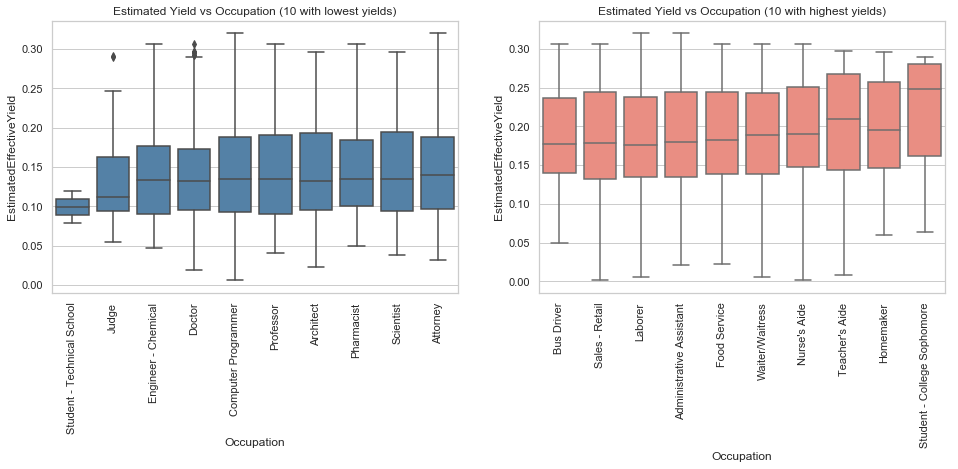

In [21]:
sns.set(style='whitegrid')
fix, ax=plt.subplots(ncols=2, figsize=[16,5])

occupation_lowyield = df_postitive_yield.groupby('Occupation')['EstimatedEffectiveYield'].mean().sort_values().head(10).index
occupation_highyield = df_postitive_yield.groupby('Occupation')['EstimatedEffectiveYield'].mean().sort_values().tail(10).index

df_temp_low = df_postitive_yield[df_postitive_yield.Occupation.isin(occupation_lowyield)]
df_temp_high = df_postitive_yield[df_postitive_yield.Occupation.isin(occupation_highyield)]

sns.boxplot(x=df_temp_low.Occupation, y=df_temp_low.EstimatedEffectiveYield, 
            color='steelblue', order=occupation_lowyield, ax=ax[0])
ax[0].set_xticklabels(occupation_lowyield, rotation=90)
ax[0].set_title('Estimated Yield vs Occupation (10 with lowest yields)')


sns.boxplot(x=df_temp_high.Occupation, y=df_temp_high.EstimatedEffectiveYield, 
            color='salmon', order=occupation_highyield, ax=ax[1])
ax[1].set_xticklabels(occupation_highyield, rotation=90)
ax[1].set_title('Estimated Yield vs Occupation (10 with highest yields)');

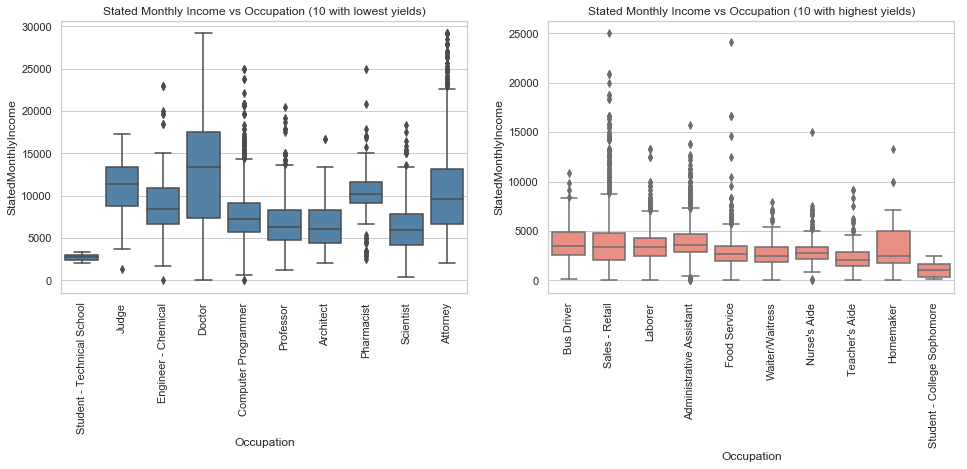

In [22]:
fix, ax=plt.subplots(ncols=2, figsize=[16,5])

mask_low = df_temp_low.StatedMonthlyIncome<30000
mask_high = df_temp_high.StatedMonthlyIncome<30000

sns.boxplot(x=df_temp_low[mask_low].Occupation, y=df_temp_low[mask_low].StatedMonthlyIncome, 
            color='steelblue', order=occupation_lowyield, ax=ax[0])
ax[0].set_xticklabels(occupation_lowyield, rotation=90)
ax[0].set_title('Stated Monthly Income vs Occupation (10 with lowest yields)')


sns.boxplot(x=df_temp_high[mask_high].Occupation, y=df_temp_high[mask_high].StatedMonthlyIncome, 
            color='salmon', order=occupation_highyield, ax=ax[1])
ax[1].set_xticklabels(occupation_highyield, rotation=90)
ax[1].set_title('Stated Monthly Income vs Occupation (10 with highest yields)');

## Thank you!

Additional analysis accross multitude of variables availble in a separate report attached.

`jupyter nbconvert ProsperLoanAnalysisDeck.ipynb --to slides --post serve --template output_toggle`
